# Brain MRI Images for Brain Tumor Detection
## Deep Learning (CNN)

The Brain MRI Images for Brain Tumor Detection dataset contains two types of data, tumorous and non-tumorous. The creator 
of the data set did not specify what types of tumors are present in the toumorus data, so all data with tumors can be 
treated as potentially the same.

In the data augmentations section we improved the variety in the population of our data and also attempted to correct
for any class imbalances in the data. In this section, we first crop and resize the data then we use a convolutional 
neural network to attempt to classify if an image is tumorous or non-tumorous.

You can find the original data [here](https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection).

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import glob

%matplotlib inline

## Data Preparation & Preprocessing

To improve the attentiveness and the features our model is learning, we first crop the images to contain only the image of the brain.
We can accomplish this by using a technique to find "extreme points in contours", which will locate the top, bottom, left 
and right most points of the brain in the image.

[Finding extreme points in contours with OpenCV](https://www.pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/)

In [2]:
def create_contour(extreme_img, contour_data):
    c, extLeft, extRight, extTop, extBot = contour_data
    
    # draw the outline of the object, then draw each of the
    # extreme points, where the left-most is red, right-most
    # is green, top-most is blue, and bottom-most is teal
    cv2.drawContours(extreme_img, [c], -1, (0, 255, 255), 2)
    cv2.circle(extreme_img, extLeft, 8, (0, 0, 255), -1)
    cv2.circle(extreme_img, extRight, 8, (0, 255, 0), -1)
    cv2.circle(extreme_img, extTop, 8, (255, 0, 0), -1)
    cv2.circle(extreme_img, extBot, 8, (255, 255, 0), -1)
    
    return extreme_img


def plot_imgs(original_img, new_img, contour_data):
    plt.figure()

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(original_img)
    plt.tick_params(axis='both', which='both', 
                    top=False, bottom=False, left=False, right=False,
                    labelbottom=False, labeltop=False, labelleft=False, labelright=False)
    plt.title('Original Image')
    
    # Extreme Image
    extreme_img = create_contour(original_img.copy(), contour_data)
     
    plt.subplot(1, 3, 2)
    plt.imshow(extreme_img)
    plt.tick_params(axis='both', which='both', 
                    top=False, bottom=False, left=False, right=False,
                    labelbottom=False, labeltop=False, labelleft=False, labelright=False)
    plt.title('Extreme Image')
    
    # Cropped Image    
    plt.subplot(1, 3, 3)
    plt.imshow(new_img)
    plt.tick_params(axis='both', which='both', 
                    top=False, bottom=False, left=False, right=False,
                    labelbottom=False, labeltop=False, labelleft=False, labelright=False)
    plt.title('Cropped Image')
    
    plt.show()
        
        
def crop_contour(img, plot=False):
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    
    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_img = img[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plot_imgs(img, new_img, (c, extLeft, extRight, extTop, extBot))
    
    return new_img

We can see the cropping process in action here, where we see the original image, the image with the extremes identified and
the final cropped image.

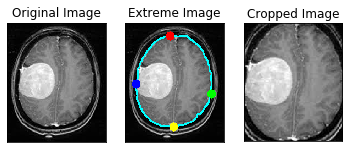

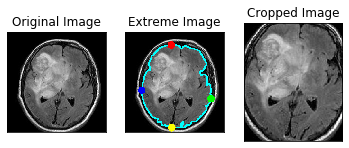

In [3]:
ex_img = cv2.imread('data/raw/yes/Y1.jpg')
ex_new_img = crop_contour(ex_img, True)

ex_img = cv2.imread('data/raw/yes/Y2.jpg')
ex_new_img = crop_contour(ex_img, True)

### Load up the data:

We then load the data, first cropping the image as we did above, then resizing the image to a standard 240, 240 size. 
We then normalize the pixel values to improve the training of the neural network. Finally we shuffle the data so we don't
have a chunk of all negatives then a chunk of all positives.

In [4]:
def load_data(dir, image_size):
    image_width, image_height = image_size
    X = []
    y = []
    
    for file in glob.glob(dir + "no/*"):
        image = cv2.imread(file)
        # crop image
        image = crop_contour(image, plot=False)
        # resize image
        image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
        # normalize
        image = image / 255.

        X.append(np.array(image))
        y.append([0])
        
    for file in glob.glob(dir + "yes/*"):
        image = cv2.imread(file)
        # crop image
        image = crop_contour(image, plot=False)
        # resize image
        image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
        # normalize
        image = image / 255.

        X.append(np.array(image))
        y.append([1])

    X = np.array(X)
    y = np.array(y)
    
    # Shuffle
    X, y = shuffle(X, y)
    
    return X, y

In [5]:
dir_path = 'data/augmented/'
IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data(dir_path, (IMG_WIDTH, IMG_HEIGHT))

### Sample Images
We now will take a look at some of the images that we will be classifying in order to get an idea of what our
data looks like after all the preprocessing.

In [6]:
def plot_sample_images(X, y, n=50):
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
               
        for i, image in enumerate(n_images):
            plt.subplot(rows_n, columns_n, i + 1)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

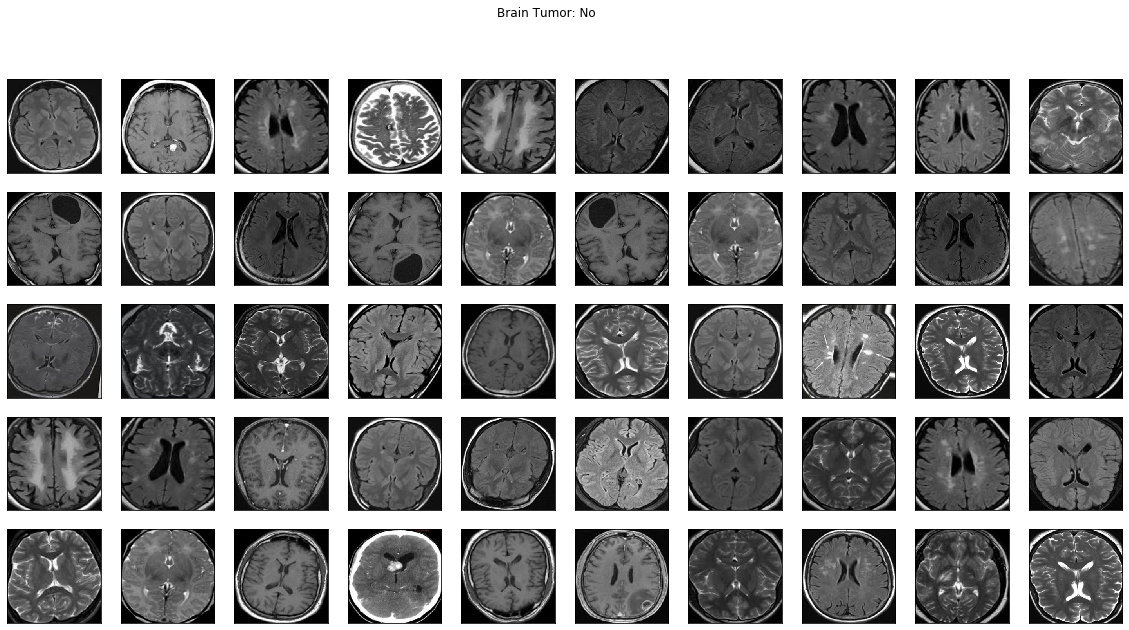

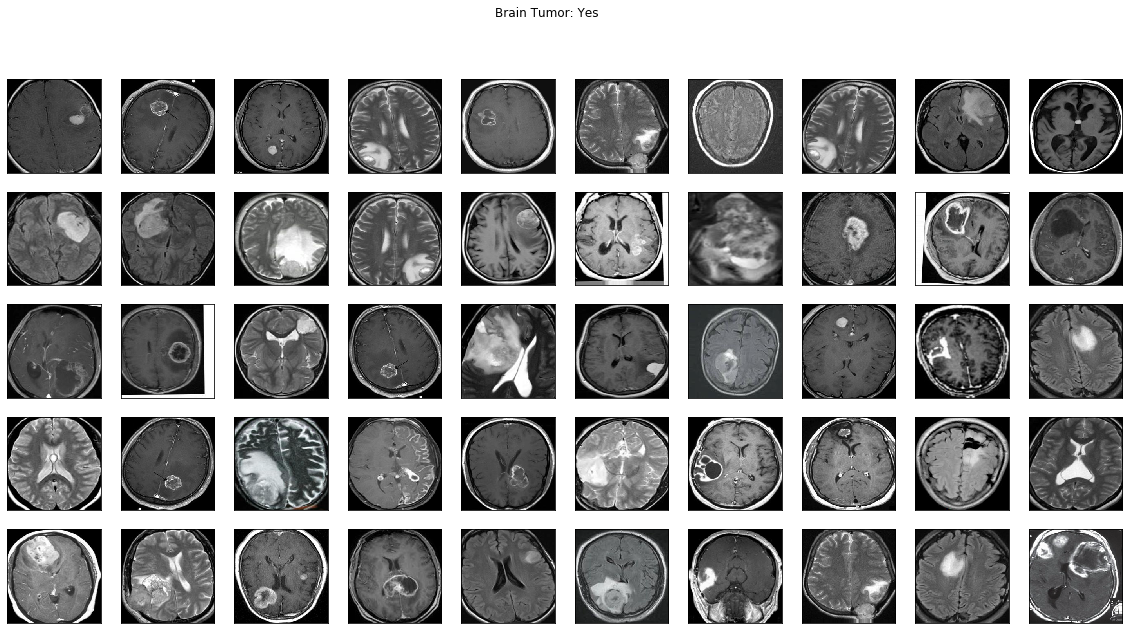

In [7]:
plot_sample_images(X, y)

We then split our data into training, validation and test. We use a 80/10/10 split for the data.

In [8]:
def split_data(X, y, test_size=0.2):
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [9]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.2)

print ("Train Samples: " + str(X_train.shape[0]))
print ("Validation Samples: " + str(X_val.shape[0]))
print ("Test Samples: " + str(X_test.shape[0]))

Train Samples: 1566
Validation Samples: 196
Test Samples: 196


In [10]:
def compute_f1_score(y_true, y_prob):
    y_pred = np.where(y_prob > 0.5, 1, 0)
    score = f1_score(y_true, y_pred)
    
    return score

In [11]:
# Building the CNN

IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

inputs = Input(IMG_SHAPE)
_ = ZeroPadding2D((2, 2))(inputs)

_ = Conv2D(32, (7, 7), strides=(1, 1))(_)
_ = BatchNormalization(axis=3)(_)
_ = Activation('relu')(_)

_ = MaxPooling2D((4, 4))(_)
_ = MaxPooling2D((4, 4))(_)

_ = Flatten()(_)
_ = Dense(1, activation='sigmoid')(_)

model = Model(inputs=inputs, outputs=_)

W0902 21:43:16.953999  9788 deprecation.py:506] From D:\Anaconda3\envs\deeplearning\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [12]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
model.fit(x=X_train, y=y_train, batch_size=32, epochs=50, 
          validation_data=(X_val, y_val), 
          callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

history = model.history.history

W0902 21:56:40.819446  9788 deprecation.py:323] From D:\Anaconda3\envs\deeplearning\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 244, 244, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 238, 238, 32)      4736      
_________________________________________________________________
batch_normalization (BatchNo (None, 238, 238, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 238, 238, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 59, 59, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0     

## Ploting Loss & Accuracy

In [13]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['acc']
    val_acc = history['val_acc']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

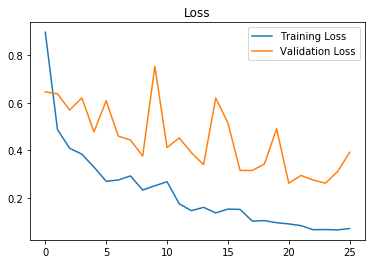

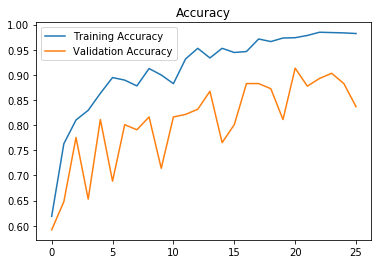

In [14]:
plot_metrics(history) 

## Results

In [17]:
loss, acc = model.evaluate(x=X_test, y=y_test)
print (f"Test Loss: {loss}")
print (f"Test Accuracy: {acc}")

y_test_prob = model.predict(X_test)
f1score = compute_f1_score(y_test, y_test_prob)
print(f"F1 score: {f1score}")


196/196 [==============================] - 1s 4ms/sample - loss: 0.2761 - acc: 0.8776
Test Loss: 0.2761093603104961
Test Accuracy: 0.8775510191917419
F1 score: 0.896551724137931


## Conclusion
In conclusion we achieved pretty quality results with a test accuracy of 0.878 and an F1 score of 0.897 on the test data. We managed to
overcome the initial issue of having a very small amount of data by using data augmentation to assist in creating a more
diverse population for our model to learn on. We also used augmentation to assist in balancing our dataset. We then used 
extreme point contours to crop our images automatically to a more localized version of the image to improve our classification.
And finally we used a CNN to process the images and classify the tumors with decent accuracy. With more hyperparamater tuning
perhaps this model could perform even better!